In [ ]:
%%bash 
pip install -q facenet-pytorch 
pip install -q torchinfo 

In [56]:
from facenet_pytorch import MTCNN
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from tqdm import tqdm 
from PIL import Image 
import cv2 
import os 
import time 
import numpy as np 
from torchinfo import summary 
from glob import glob 
import matplotlib.pyplot as plt
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score

In [55]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
torch.manual_seed(0)
np.random.seed(0)

cpu


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

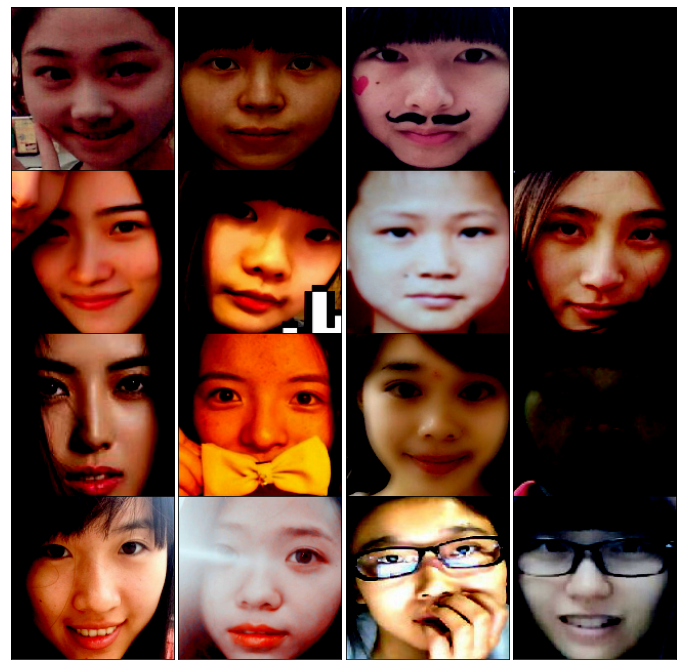

In [32]:
img_path = "AFAD-Lite/18/112/*.jpg"
img_list = [img for img in glob(img_path)]
mtcnn = MTCNN()
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
ax = axes.ravel()
for i in range(16):
    img = Image.open(img_list[i])
    img = img.convert("RGB")
    img = np.array(img)
    img = mtcnn(img)
    ax[i].imshow(img.permute(1, 2, 0))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

---
目的：　既存の学習済モデルの使用されたデータセットでは人種の偏りが大きいと予想されるので、アジア民のデータを使って転移学習を試みる。ここでの損失関数として年齢によるに乗誤差と性別のエントロピーを用いることで精度を高めるモデルを構築する。推論時には１次元に変換されたベクトルのみ出力し、画像間のコサイン類似度を算出。これによって顔認証のモデルを作成すること.


---

In [43]:
class MyDataSet(object):
    def __init__(self, resize=160):
        self.files = []
        self.age = []
        self.sex = []
        self.resize = resize 
        self.trans = Transform(self.resize)
        self._load()

    def _load(self):
        for f in glob("AFAD-Lite/[0-9][0-9]/*/*.jpg"):
            age = f.split("/")[1]
            sex = f.split("/")[2]
            self.files.append(str(f))
            self.age.append(int(age))
            self.sex.append(int(sex)-111)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        img_tensor = self.trans(img) # (3, 160, 160)
        age_tensor = torch.tensor(self.age[idx], dtype=torch.float32)
        sex_tensor = torch.tensor(self.sex[idx])
        return img_tensor, age_tensor, sex_tensor 

    def __len__(self):
        return len(self.files)


class Transform():
    def __init__(self, resize):
        self.resize = resize 
        self.transform = transforms.Compose([
                                             transforms.Resize((resize, resize)),
                                             transforms.ToTensor(),
                                             transforms.Lambda(lambda x: x*2-1) # -1~1の正規化処理
        ])

    def __call__(self, img):
        return self.transform(img)

mydata = MyDataSet()


In [44]:
mydata.__getitem__(1)

(tensor([[[-0.8196, -0.7882, -0.7647,  ..., -0.8510, -0.8431, -0.8353],
          [-0.7804, -0.7569, -0.7412,  ..., -0.8510, -0.8510, -0.8431],
          [-0.7569, -0.7333, -0.7176,  ..., -0.8510, -0.8510, -0.8431],
          ...,
          [-0.3255, -0.3333, -0.3569,  ..., -0.3725, -0.3569, -0.3333],
          [-0.3255, -0.3333, -0.3490,  ..., -0.3412, -0.3490, -0.3412],
          [-0.3255, -0.3333, -0.3412,  ..., -0.3333, -0.3569, -0.3569]],
 
         [[-0.8118, -0.7804, -0.7569,  ..., -0.8510, -0.8431, -0.8353],
          [-0.7725, -0.7490, -0.7333,  ..., -0.8510, -0.8510, -0.8431],
          [-0.7490, -0.7255, -0.7098,  ..., -0.8510, -0.8510, -0.8431],
          ...,
          [ 0.0667,  0.0588,  0.0353,  ..., -0.2157, -0.2157, -0.2000],
          [ 0.0667,  0.0588,  0.0431,  ..., -0.1843, -0.2078, -0.2078],
          [ 0.0667,  0.0588,  0.0510,  ..., -0.1765, -0.2157, -0.2235]],
 
         [[-0.8510, -0.8196, -0.7961,  ..., -0.8667, -0.8588, -0.8510],
          [-0.8118, -0.7882,

In [45]:
batch_size = 32
train_dl = torch.utils.data.DataLoader(dataset=mydata, batch_size=batch_size, shuffle=True, drop_last=True)

In [53]:
class AsiaFaceNet(nn.Module):
    def __init__(self):
        super(AsiaFaceNet, self).__init__()
        self.facenet = InceptionResnetV1(pretrained="vggface2") # -> (b, 512)
        self.agenet = nn.Linear(512, 1)
        self.sexnet = nn.Linear(512, 2)

        for name, weight in self.facenet.named_parameters():
            if name in ["last_linear.weight", "last_bn.weight", "last_bn.bias"]:
                weight.requires_grad = True 
            else:
                weight.requires_grad = False 

    def forward(self, x):
        y = self.facenet(x)
        sex = self.sexnet(y)
        age = F.hardtanh(self.agenet(y), 15, 39)
        return y, sex, age 

net = AsiaFaceNet()

In [54]:
summary(net, input_size=(2, 3, 160, 160))

Layer (type:depth-idx)                             Output Shape              Param #
AsiaFaceNet                                        --                        --
├─InceptionResnetV1: 1-1                           [2, 512]                  --
│    └─BasicConv2d: 2-1                            [2, 32, 79, 79]           --
│    │    └─Conv2d: 3-1                            [2, 32, 79, 79]           (864)
│    │    └─BatchNorm2d: 3-2                       [2, 32, 79, 79]           (64)
│    │    └─ReLU: 3-3                              [2, 32, 79, 79]           --
│    └─BasicConv2d: 2-2                            [2, 32, 77, 77]           --
│    │    └─Conv2d: 3-4                            [2, 32, 77, 77]           (9,216)
│    │    └─BatchNorm2d: 3-5                       [2, 32, 77, 77]           (64)
│    │    └─ReLU: 3-6                              [2, 32, 77, 77]           --
│    └─BasicConv2d: 2-3                            [2, 64, 77, 77]           --
│    │    └─Conv2d: 3-7

In [ ]:
def show_plot_loss(losses):
    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(len(losses)).tolist(), losses)
    plt.xticks([])
    plt.title("iteration of loss mean")
    plt.show()

def trainer(net, img, sex, age, optimizer, criterion_age, criterion_sex):
    out_vec, out_sex, out_age = net(img)
    loss_age = criterion_age(out_age.view(-1), age)
    loss_sex = criterion_sex(out_sex, sex)
    total_loss = loss_age+loss_sex 

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    return total_loss

def train(train_dl, net, num_epoch, lr=1e-5, print_loss=100, plot_loss=200):
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    criterion_age = torch.nn.L1Loss() # 年齢の回帰誤差
    criterion_sex = torch.nn.CrossEntropyLoss() # 男女の多値分類
    net.to(device)
    plot = []

    for e in range(num_epoch):
        net.train()
        losses, plot_losses = [], []
        for i, (img, sex, age) in enumerate(tqdm(train_dl)):
            img = img.to(device)
            sex = sex.to(device)
            age = age.to(device)

            loss = trainer(net, img, sex, age, optimizer, criterion_age, criterion_sex)
            losses.append(loss.item().cpu().numpy())
            plot_losses.append(loss.item().cpu().numpy())

            if i%print_loss == 0:
                print(f"train loss: {np.mean(losses):.4f}")
                losses = []
            if i%plot_loss == 0:
                plot.append(np.mean(plot_losses))
                plot_losses = []

    show_plot_loss(plot)
    torch.save(net.facenet.state_dict(), f"facenet{e+1}.pth")



In [ ]:
NUM_EPOCH = 1
train(train_dl, net, NUM_EPOCH)